#Model Building and Recommendation using both content and collaborative filtering

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten,Dense
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from operator import itemgetter
from sklearn.decomposition import PCA
%matplotlib inline

2.8.0


In [0]:
!pip install h5py==2.10.0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extracting data and Spliting .

In [0]:
Path = '/content/drive/MyDrive/dataset/'
df = pd.read_csv(Path +"item_user.csv")

df.head()

,Unnamed: 0,user_id,business_id,stars
0,0,92669,2999,4.0
1,1,102147,15199,4.0
2,2,111064,3741,5.0
3,3,147370,4953,2.0
4,4,2416,3690,4.0


In [0]:
df = df.drop('Unnamed: 0',axis=1)

In [0]:
nusers = df.user_id.nunique()
nbus = df.business_id.nunique()
nusers, nbus

(2189457, 160585)

In [0]:

np.random.seed=2017
train_indices, val_indices = train_test_split(range(df.shape[0]), train_size=0.8)
trdf = df.iloc[train_indices]
valdf = df.iloc[val_indices]
trdf.shape, valdf.shape

((6908322, 3), (1727081, 3))

## Base Regression model with matrix factorization 

In [0]:
REG=5e-4
L = 50

In [0]:

def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [0]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
bus_input, bLmat = embedding_input('bus_input', nbus, L, REG)

In [0]:
user_bias = create_bias('user_bias', user_input, nusers, REG)
bus_bias = create_bias('bus_bias', bus_input, nbus, REG)

In [0]:

residual = Dot(axes=2, name="residual")([uLmat, bLmat])   

In [0]:
residflat = Flatten(name="residual_flat")(residual)

In [0]:

regression = Add(name="regression")([user_bias, bus_bias, residflat])

In [0]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

In [0]:
cs = sigmoid_maker(0, 5.5)

In [0]:
output = Activation(cs, name="Sigmoid_Range")(regression)

In [0]:
model = Model([user_input, bus_input], output)
model.compile(Adam(0.01), loss='mse')

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 bus_input (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 user_factor (Embedding)        (None, 1, 50)        109472850   ['user_input[0][0]']             
                                                                                                  
 bus_factor (Embedding)         (None, 1, 50)        8029250     ['bus_input[0][0]']              
                                                                                            

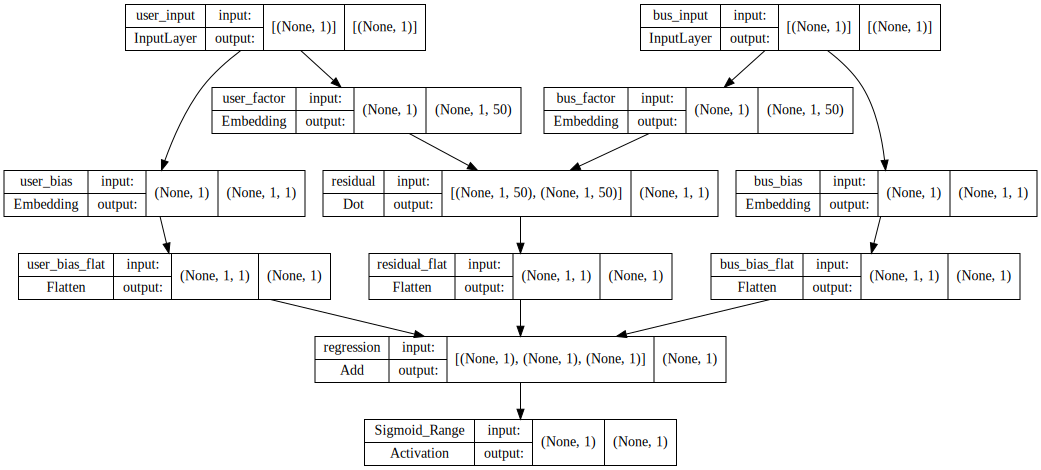

In [0]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [0]:
checkpoint_filepath = '/content/drive/MyDrive/dataset/RML-{epoch:02d}.h5'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

def schedule(epoch,lr):
  if (epoch+1)%3==0:
    return lr*10
  else:
    return lr

Lrdecay = tf.keras.callbacks.LearningRateScheduler(schedule)
#model.optimizer.lr=0.001

In [0]:

with tensorflow.device('/device:GPU:0'):
  model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=1024, epochs=3, 
          validation_data=([valdf.user_id, valdf.	business_id], valdf.stars),use_multiprocessing = True,callbacks = [model_checkpoint_callback])

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:439: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 109472850 elements. This may consume a large amount of memory.
  num_elements)


6747/6747 [==============================] - 639s 94ms/step - loss: 1.7982 - val_loss: 1.6421
Epoch 2/3
6747/6747 [==============================] - 638s 95ms/step - loss: 1.3682 - val_loss: 1.6819
Epoch 3/3
6747/6747 [==============================] - 637s 94ms/step - loss: 1.2260 - val_loss: 1.7332


In [0]:
model.save_weights("/content/drive/MyDrive/dataset/RML.h5")

## Adding dense layers to the flattened factorized matrix -- How can this help?

In [0]:
l2=regularizers.l2(0.1)
x = Dense(64 , activation = 'relu',kernel_regularizer=l2)(residflat)
x = Dense(32, activation = 'relu',kernel_regularizer=l2)(x)
x = Dense(32, activation = 'relu',kernel_regularizer=l2)(x)
regression = Add(name="regression")([user_bias, bus_bias, x])
output = Activation(cs, name="Sigmoid_Range")(regression)


In [0]:
model1 = Model([user_input, bus_input], output)
model1.compile(Adam(0.01), loss='mse')

In [0]:

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 bus_input (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 user_factor (Embedding)        (None, 1, 50)        109472850   ['user_input[0][0]']             
                                                                                                  
 bus_factor (Embedding)         (None, 1, 50)        8029250     ['bus_input[0][0]']              
                                                                                              

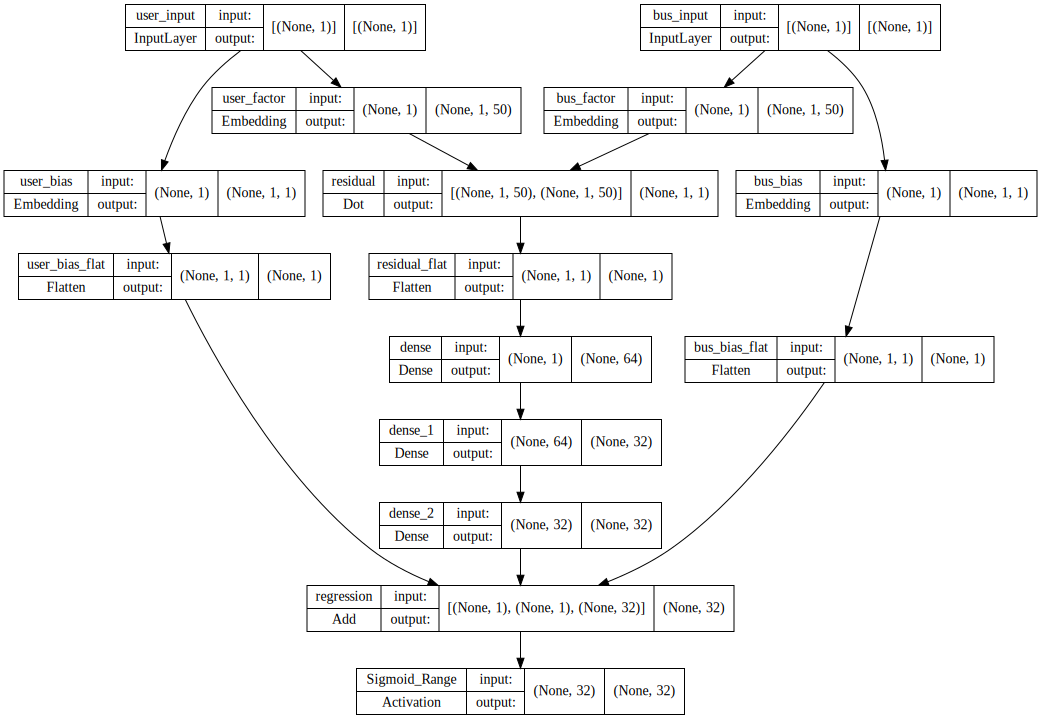

In [0]:
SVG(model_to_dot(model1,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [0]:
checkpoint_filepath = '/content/drive/MyDrive/dataset/RMnl3{epoch:02d}.h5'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

def schedule(epoch,lr):
  if (epoch+1)%2==0:
    return lr*10
  else:
    return lr

Lrdecay = tf.keras.callbacks.LearningRateScheduler(schedule)

In [0]:
with tensorflow.device('/device:GPU:0'):
  model1.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=1024, epochs=5, 
          validation_data=([valdf.user_id, valdf.	business_id], valdf.stars),use_multiprocessing = True,callbacks = [model_checkpoint_callback])

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:439: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 109472850 elements. This may consume a large amount of memory.
  num_elements)


6747/6747 [==============================] - 664s 98ms/step - loss: 1.7570 - val_loss: 1.6379
Epoch 2/5
6747/6747 [==============================] - 657s 97ms/step - loss: 1.3679 - val_loss: 1.6805
Epoch 3/5
6747/6747 [==============================] - 641s 95ms/step - loss: 1.2260 - val_loss: 1.7336
Epoch 4/5
6747/6747 [==============================] - 652s 97ms/step - loss: 1.1497 - val_loss: 1.7769
Epoch 5/5
6747/6747 [==============================] - 654s 97ms/step - loss: 1.1077 - val_loss: 1.8086


In [0]:
model1.save_weights("/content/drive/MyDrive/dataset/RMnlff.h5") #dataset/RMnlf.h5")

In [0]:
model1.load_weights('/content/drive/MyDrive/dataset/RMnlff.h5')

#### Well both performed almost same!! 


##Recommendation using both content and collaborative filtering 

Using the data base previously created using the preprocessed data 

In [0]:
import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict
import sqlite3 as sql

In [0]:
ls

drive/  sample_data/  yelp_database.db


In [0]:
def make_query(sel):
  conn = sql.connect("/content/drive/MyDrive/dataset/yelp_database.db")
  cursor = conn.cursor()
  cursor.execute(sel)
  return cursor.fetchall()

In [0]:
def make_frame(sel):
  conn = sql.connect("/content/drive/MyDrive/dataset/yelp_database.db")
  df = pd.read_sql(sel,conn)
  return df
  

In [0]:
print('Explore database : ',make_query("SELECT name FROM sqlite_master WHERE type='table';"))

Explore database :  [('bussiness',), ('reviews',), ('item_user',), ('tips',), ('users',)]


In [0]:
bus_cols = [e[1] for e in make_query("PRAGMA table_info(bussiness);")]
user_cols = [e[1] for e in make_query("PRAGMA table_info(users);")]
item_user_cols = [e[1] for e in make_query("PRAGMA table_info(item_user);")]
reviews_cols = [e[1] for e in make_query("PRAGMA table_info(reviews);")]

print('Business columns',bus_cols)
print('User cols',user_cols)
print('Item user columns',item_user_cols)
print('Review columns',reviews_cols)

Business columns ['index', 'business_id', 'name', 'address', 'city', 'state', 'postal code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'RestaurantsTableService', 'BikeParking', 'BusinessAcceptsCreditCards', 'RestaurantsReservations', 'WheelchairAccessible', 'Caters', 'OutdoorSeating', 'RestaurantsGoodForGroups', 'HappyHour', 'BusinessAcceptsBitcoin', 'HasTV', 'DogsAllowed', 'RestaurantsTakeOut', 'RestaurantsAttire', 'RestaurantsDelivery', 'BusinessParking_garage', 'BusinessParking_street', 'BusinessParking_validated', 'BusinessParking_lot', 'BusinessParking_valet', 'Ambience_touristy', 'Ambience_hipster', 'Ambience_romantic', 'Ambience_divey', 'Ambience_intimate', 'Ambience_trendy', 'Ambience_upscale', 'Ambience_classy', 'Ambience_casual', 'GoodForMeal_dessert', 'GoodForMeal_latenight', 'GoodForMeal_lunch', 'GoodForMeal_dinner', 'GoodForMeal_brunch', 'GoodForMeal_breakfast', 'NoiseLevel', 'Alcohol', 'RestaurantsPriceRange2', 'WiFi', 'Monday', 'Tuesday', 'Wednesday', 

In [0]:
df_rev = make_frame('select user_id,business_id,stars from reviews')

In [0]:
df_rev.head()

,user_id,business_id,stars
0,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0
1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0
2,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0
3,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0
4,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0


In [0]:
df = make_frame('select user_id,business_id,stars from item_user')
df.head()

,user_id,business_id,stars
0,92669,2999,4.0
1,102147,15199,4.0
2,111064,3741,5.0
3,147370,4953,2.0
4,2416,3690,4.0


In [0]:
userid_to_idx = {user : idx for idx, user in enumerate(df_rev.user_id.unique())}

In [0]:
user_df = make_frame(f'select * from users limit 200') 
user_df

,index,Unnamed: 0,user_id,name,review_count,friends,useful,funny,cool,fans,average_stars,compliment_hot,is_open,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer
0,0,0,0,Jane,1220,"xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",15038,10030,11291,1357,3.85,1710,163,190,361,147,1212,5691,2541,2541,815,323
1,1,1,1,Gabi,2136,"XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",21272,10289,18046,1025,4.09,1632,87,94,232,96,1187,3293,2205,2205,472,294
2,2,2,2,Jason,119,"GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ...",188,128,130,16,3.76,22,1,3,0,0,5,20,31,31,3,1
3,3,3,3,Kat,987,"HQZPQhKMwRAyS6BCselVWQ, kP2U1s_sjQfHO9grxiyDTA...",7234,4722,4035,420,3.77,1180,129,93,219,90,1120,4510,1566,1566,391,326
4,4,4,4,Christine,495,"-Q88pZUcrfN0BLBDp-bkAQ, etPn4Pv1Gc4cRZjRgB_BOw...",1577,727,1124,47,3.72,248,19,32,16,15,77,131,310,310,98,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,195,Michael,13,"M_FOYzrx4aUMajSjSOIMlQ, 6VgHF_5Q6vsMqmkj9ENwwQ...",22,7,8,1,4.00,1,2,0,0,0,1,0,1,1,1,0
196,196,196,196,Anna,228,"oK9ZAXrvOfTvd0X7wLQ9Dg, G_Ww3TYrXzuAlzXyf1EekA...",564,286,370,63,4.11,52,6,0,3,0,34,31,64,64,21,13
197,197,197,197,Dina,87,"CMBYyVy2Rwb_saUkY5kZaQ, GhPyF1QarMjl_C3aXuWu_w...",291,142,123,10,3.43,10,2,0,1,0,21,27,17,17,18,2
198,198,198,198,Robert,57,"G-H7SbiqNvuZQtPmL3o2dQ, arw8-67aaImIyDX6mHWnxw...",27,12,17,1,4.21,3,0,0,0,0,1,0,3,3,0,0


In [0]:
ll= ['RestaurantsTableService',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'RestaurantsReservations',
 'WheelchairAccessible',
 'Caters',
 'OutdoorSeating',
 'RestaurantsGoodForGroups',
 'HappyHour',
 'BusinessAcceptsBitcoin',
 'HasTV',
 'DogsAllowed',
 'RestaurantsTakeOut',
 'RestaurantsAttire',
 'RestaurantsDelivery', 'BusinessParking_garage',
 'BusinessParking_street',
 'BusinessParking_validated',
 'BusinessParking_lot',
 'BusinessParking_valet',
 'Ambience_touristy',
 'Ambience_hipster',
 'Ambience_romantic',
 'Ambience_divey',
 'Ambience_intimate',
 'Ambience_trendy',
 'Ambience_upscale',
 'Ambience_classy',
 'Ambience_casual',
 'GoodForMeal_dessert',
 'GoodForMeal_latenight',
 'GoodForMeal_lunch',
 'GoodForMeal_dinner',
 'GoodForMeal_brunch',
 'GoodForMeal_breakfast']

In [0]:
OA = ['NoiseLevel','Alcohol','RestaurantsPriceRange2','WiFi']

# First -- Recommend restaurants to a user 

To a given user first we filtered the resataurants he/she previously visited and extract his/her friends details and filter out the most rated restaurants , and creating a new dataframe of restaurant with users history , freinds .

Now we use this user id + freinds id , restaurent id together to predict the users raings using the model. 

To that we scanned the new dataframe created , extracted the Attributes of restaurent which were highly rated by the user 

In [0]:
def recommend(n):
  u = user_df.user_id.loc[n]
  user_pl = df[df.user_id == u]
  t = tuple(user_pl.business_id)
  bus_pl = make_frame(f'select * from bussiness WHERE business_id in {t} ORDER BY stars DESC limit 5')
  bus_pl['user_id'] = u

  if user_df.iloc[n,3] != 'None' :
    flist =user_df.iloc[n,5].split(',')
    id =[]
    for j in flist:
      var = j.lstrip(' ')
      if var in userid_to_idx.keys():
        id.append(userid_to_idx[var])
        bus_pl_f = make_frame(f'select * from bussiness WHERE business_id in ({userid_to_idx[var]}) ORDER BY stars DESC limit 5')
        bus_pl_f['user_id'] = userid_to_idx[var]
        bus_pl= pd.concat([bus_pl,bus_pl_f], ignore_index=True)

  bus_pl['business_id'] = bus_pl['business_id'].astype(int)
  bus_pl['pred_stars'] = model1.predict([bus_pl.user_id, bus_pl.business_id]).mean(axis=1).ravel() -0.5

  preds_stats=bus_pl.groupby('stars')['pred_stars'].describe().reset_index()
  plt.plot([0.5,5],[0.5,5])
  plt.plot(preds_stats.stars, preds_stats['mean'], color="red")
  plt.fill_between(preds_stats.stars, preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="red", alpha=0.5)
  plt.xlabel("Average stars given by public to the restaurents")
  plt.ylabel("Predicted stars for the given user")
  plt.title("Model performance")

  print('Recommended Restaurants :')
  display(bus_pl[bus_pl.is_open == 1].sort_values('pred_stars',ascending = False)[['name','state','pred_stars']][:5] )

  fdf = bus_pl.sort_values('pred_stars',ascending = False)[['name','state','pred_stars']][:5]
  cdf = bus_pl[ll].sum(axis=0)
  bu = cdf.sort_values(ascending = False)[:20]

  fig = plt.figure(figsize = (8,8))
  p=sns.barplot(bu.index,bu.values)
  p.set_xticklabels(p.get_xticklabels(),rotation = 90,fontsize=8)
  p.set(xlabel= "Attributes" , ylabel = "Vote")
  p.set_title("User prefered attribute in the restaurent")

  fig, ax = plt.subplots(1, len(OA),figsize = (10,5))
  for i, categorical_feature in enumerate(bus_pl[OA]):
      bus_pl[categorical_feature].value_counts().plot(kind='bar', ax=ax[i]).set_title(categorical_feature)
  fig.show()

  return bu


## Second -- Recommend new restaurants or may not be new to the give user based on place or neighbour of a user preference 

We listed the places of restaurants user previously visisted , Extracted the new restaurants with less review count filtered by the places (--> Reason to improve customers in this restaurants based on the predicted rating and quality of the restaurant measured by the attributes. )

Now we predict the ratings . After this we filter out by highest rating with highest attribute count 



In [0]:
def new_restar_neigh_recom(n,Attr):
  u = user_df.user_id.loc[n]
  user_pl = df[df.user_id == u]
  t = tuple(user_pl.business_id)
  user_neigh = make_frame(f'select city from bussiness')

  neig = tuple(user_neigh.city)

  bus_new = make_frame(f'select * from bussiness WHERE city in {neig} ORDER BY review_count ASC limit 50')
  bus_new['user_id'] = u

  bus_new['business_id'] = bus_new['business_id'].astype(int)

  bus_new['pred_stars'] = model1.predict([bus_new.user_id, bus_new.business_id]).mean(axis=1).ravel() -0.5

  bus_new['Attr_count'] = bus_new[Attr.index.tolist()].sum(axis=1)

  display(bus_new.sort_values('pred_stars',ascending = False)[:5].sort_values('Attr_count',ascending = False)[['name','state','pred_stars']])

!! Let's take an example 

Recommended Restaurants :


,name,state,pred_stars
15,Plated lounge,GA,4.595122
12,Littleburg Vegetable Kitchen,MA,4.477462
21,ScoopsnBrew,FL,4.346744
17,Plow Burger,TX,4.299712
10,Cafe Mirror,MA,4.295076


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


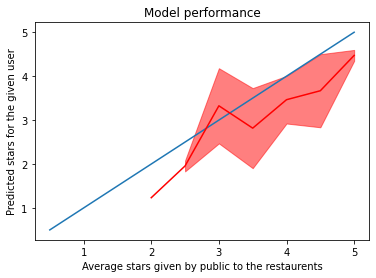

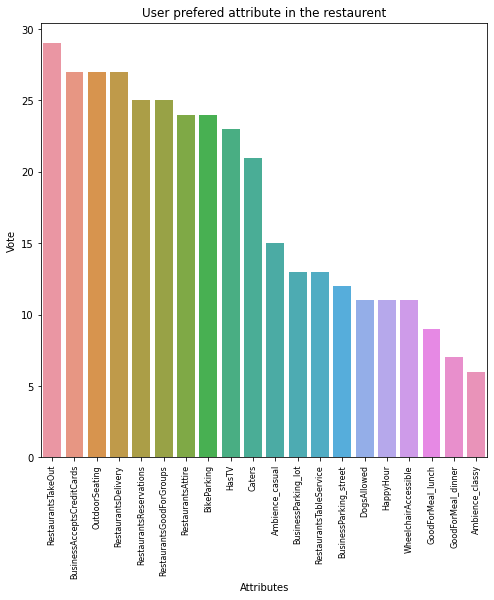

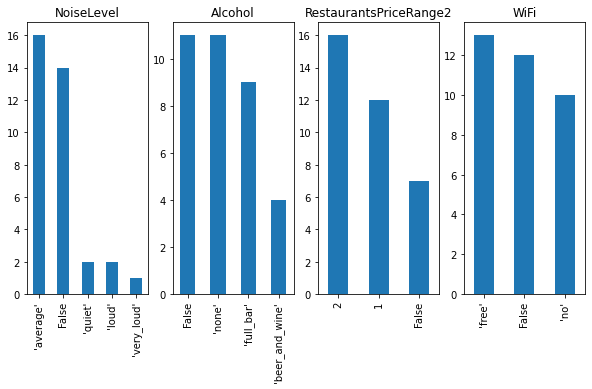

In [0]:
Choosen_user = 8
Attr = recommend(Choosen_user)

Going through the above 2 bar plots we can see what restaurant attributes user prefers . And also see how well the model predicted to the user for the restaurants 

!! Now using those attributes and neighbourhood of user , we recommend the new restaurants of similar quality. -- > Indeed favaurable to both restaurant and user :D

In [0]:
new_restar_neigh_recom(Choosen_user,Attr)

,name,state,pred_stars
4,Chocolaterie Bernard Callebaut,BC,4.521700
8,Muse 24h Caffee,FL,4.532732
28,Buttersweet Bakery,TX,4.372485
9,Mi Lupita Taqueria,TX,4.612519
10,Synergize Nutrition,FL,4.178289




This doesnt end here we can do more like recommend a restaurant to middle class user based on the additional considerations with price range and many more . 

# Model 3

## **Importing Libraries**

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## **User-Restaurant-Rating dataset**

In [0]:
user_restuarant=pd.read_csv("item_user.csv")
user_restuarant.head()

,Unnamed: 0,user_id,business_id,stars
0,0,92669,2999,4.0
1,1,102147,15199,4.0
2,2,111064,3741,5.0
3,3,147370,4953,2.0
4,4,2416,3690,4.0


In [0]:
user_restuarant.shape

(8635403, 4)

**1) Number of Unique Users**

In [0]:
len(user_restuarant["user_id"].unique())

2189457

## **Users meta Data**

In [0]:
Users_meta_data=pd.read_csv("user.csv")
Users_meta_data.head()

,user_id,name,review_count,friends,useful,funny,cool,fans,average_stars,compliment_hot,is_open,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1220,"xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",15038,10030,11291,1357,3.85,1710,163,190,361,147,1212,5691,2541,2541,815,323,NaN
1,dIIKEfOgo0KqUfGQvGikPg,Gabi,2136,"XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",21272,10289,18046,1025,4.09,1632,87,94,232,96,1187,3293,2205,2205,472,294,NaN
2,D6ErcUnFALnCQN4b1W_TlA,Jason,119,"GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ...",188,128,130,16,3.76,22,1,3,0,0,5,20,31,31,3,1,NaN
3,JnPIjvC0cmooNDfsa9BmXg,Kat,987,"HQZPQhKMwRAyS6BCselVWQ, kP2U1s_sjQfHO9grxiyDTA...",7234,4722,4035,420,3.77,1180,129,93,219,90,1120,4510,1566,1566,391,326,NaN
4,37Hc8hr3cw0iHLoPzLK6Ow,Christine,495,"-Q88pZUcrfN0BLBDp-bkAQ, etPn4Pv1Gc4cRZjRgB_BOw...",1577,727,1124,47,3.72,248,19,32,16,15,77,131,310,310,98,44,NaN


In [0]:
Users_meta_data.shape

(2189457, 21)

## **Creating Adjacency Matrix**

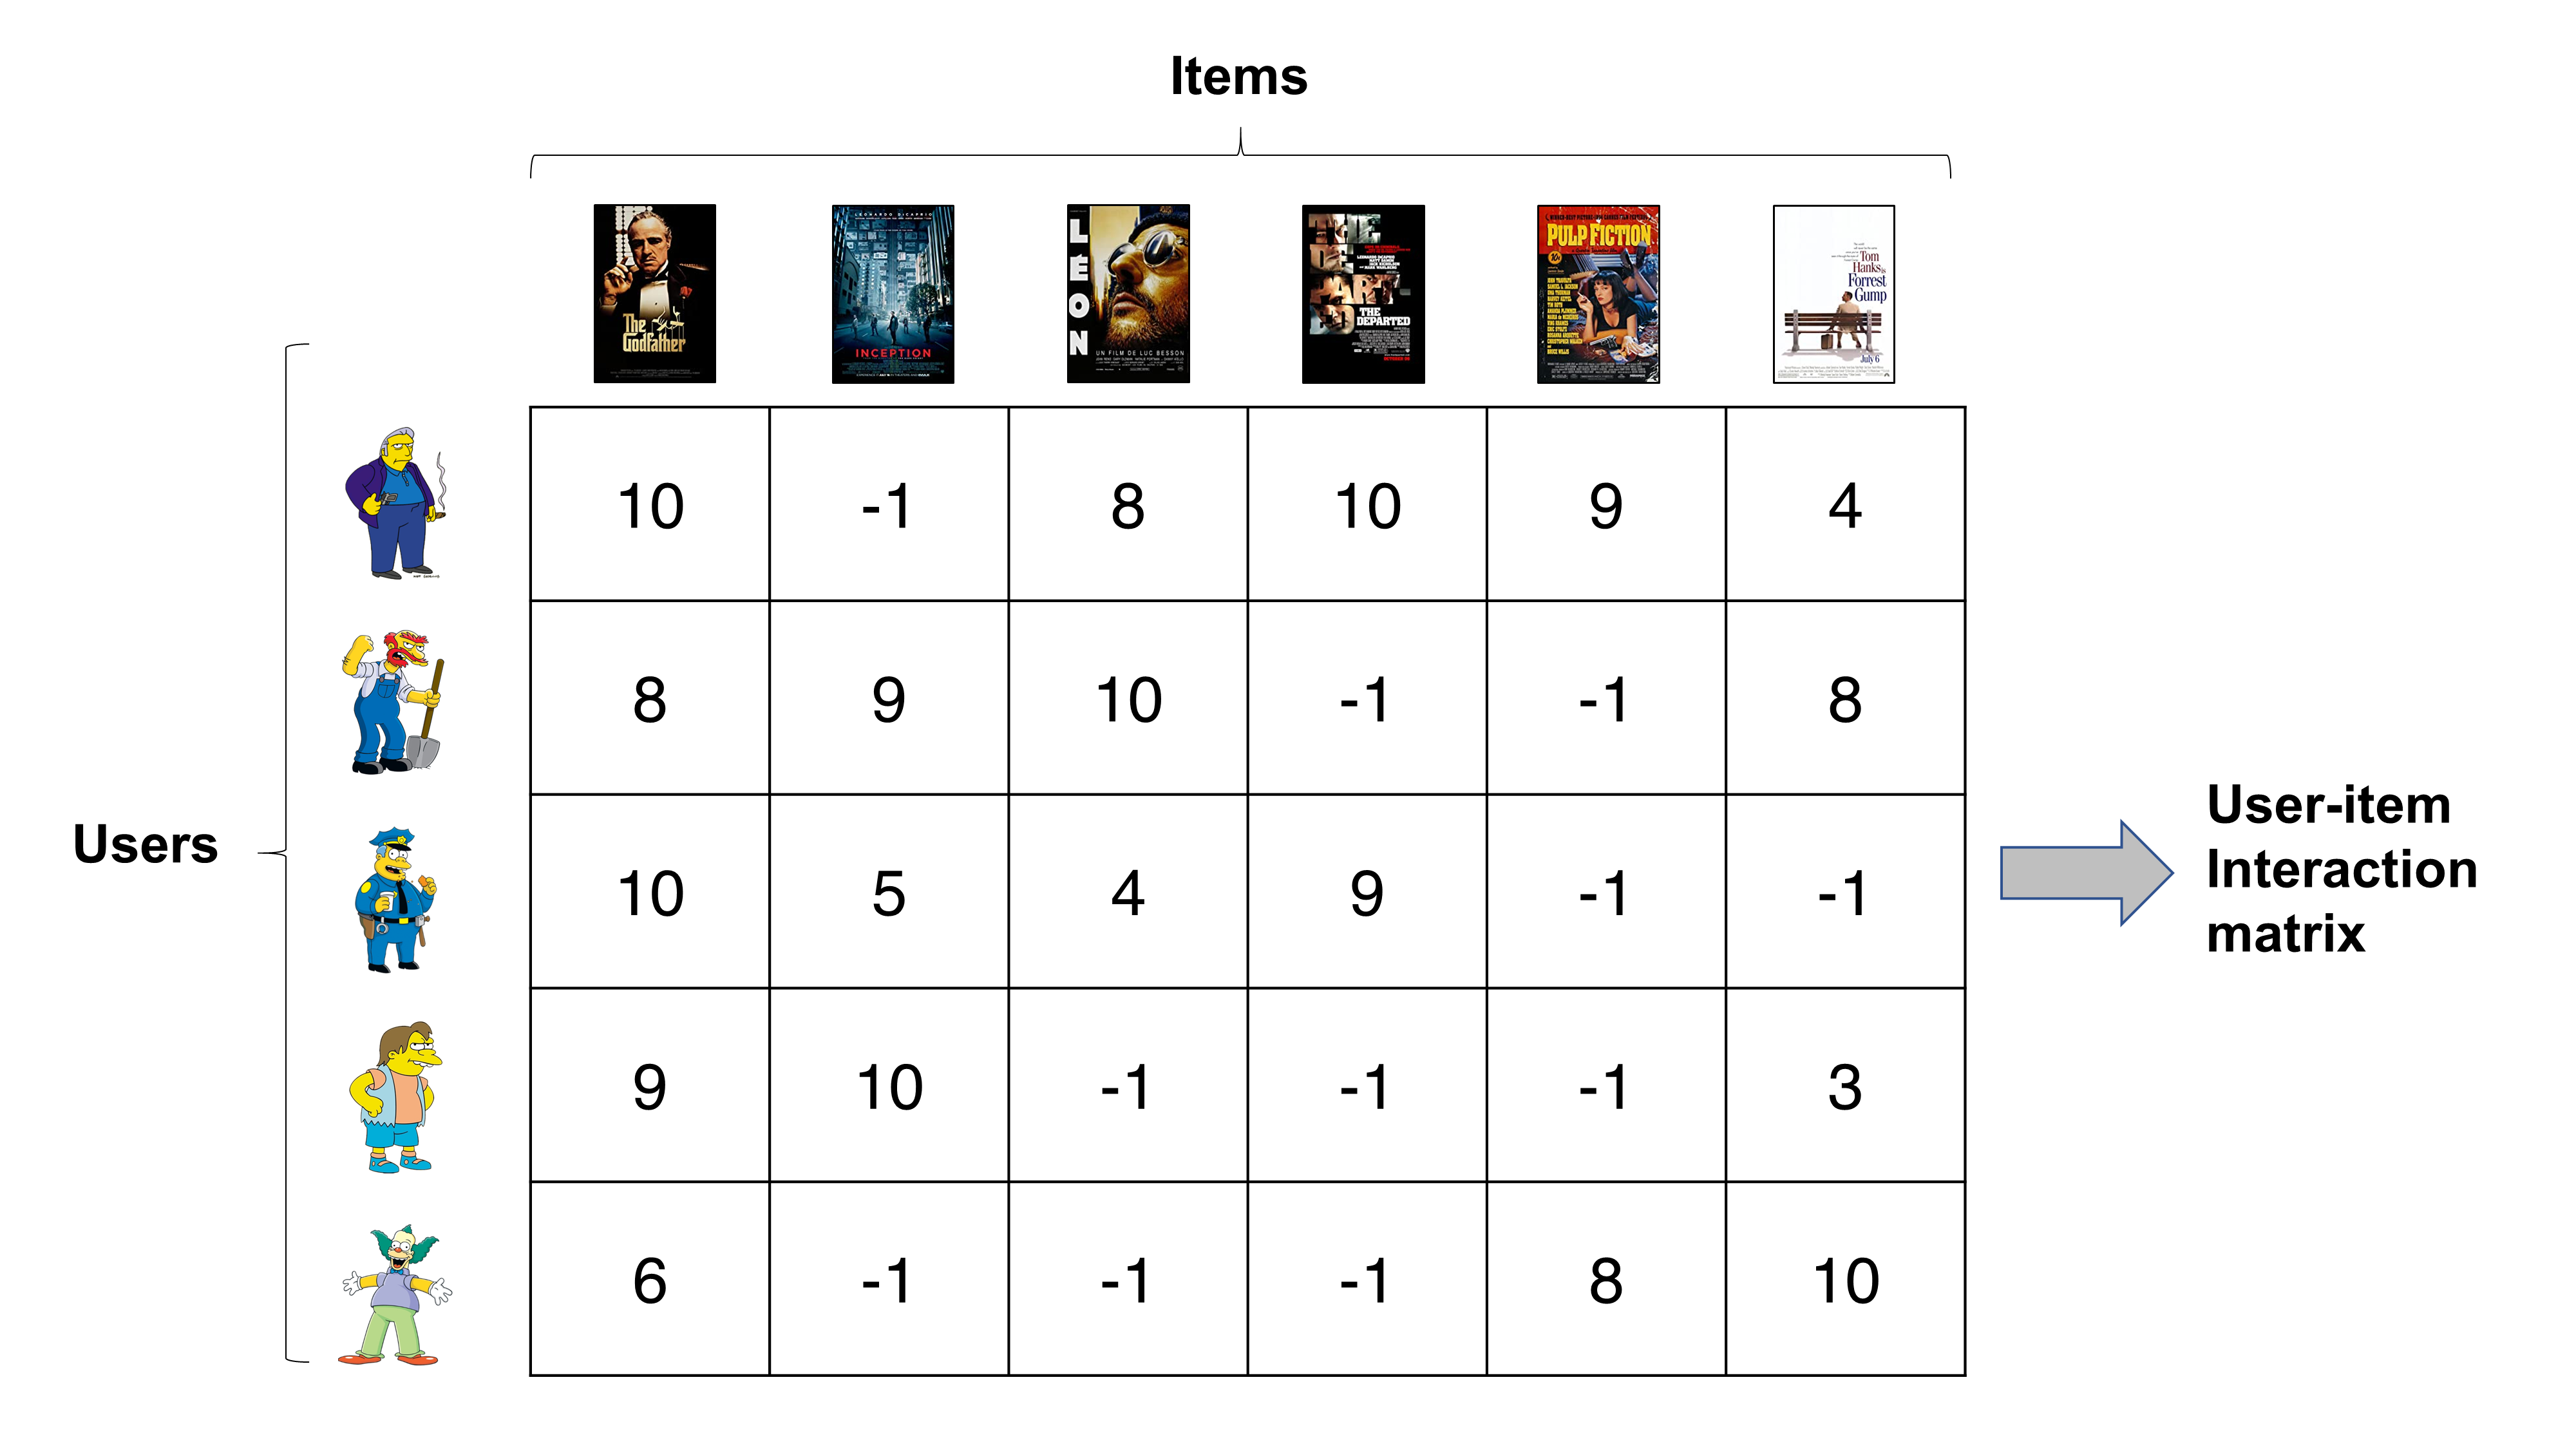

In [0]:
rows=user_restuarant['user_id'].max()+1
columns=user_restuarant['business_id'].max()+1
print(rows,columns)

2189457 160585


In [0]:
from scipy.sparse import csr_matrix

adjacency_matrix = csr_matrix((user_restuarant['stars'].values.tolist(),(user_restuarant['user_id'].values.tolist(), \
                                                                          user_restuarant['business_id'].values.tolist())),shape=(rows,columns))

adjacency_matrix.shape

(2189457, 160585)

## **Singular Value Decompositon**

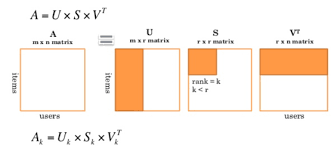


In [0]:
from sklearn.utils.extmath import randomized_svd
import numpy as np
matrix = np.random.random((20, 10))
U, Sigma, VT = randomized_svd(adjacency_matrix, n_components=5,n_iter=5, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)


(2189457, 5)
(5,)
(160585, 5)



## **Optimization**

$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$


<ul>
<li><span class="math">\(\mu\)</span> : scalar mean rating</li>
<li><span class="math">\(b_i\)</span> : scalar bias term for user <span class="math">\(i\)</span></li>
<li><span class="math">\(c_j\)</span> : scalar bias term for restaurant <span class="math">\(j\)</span></li>
<li><span class="math">\(u_i\)</span> : K-dimensional vector for user <span class="math">\(i\)</span></li>
<li><span class="math">\(v_j\)</span> : K-dimensional vector for restaurant <span class="math">\(j\)</span></li>
</ul>

 $ \ $



1) Mean rating ($\mu$)


In [0]:
def m_u(ratings):
  mean=ratings.mean()
  return mean

In [0]:
m_u(user_restuarant['stars'])

3.730958705690979

2) Initialize $B_{i}$ and $C_{j}$

In [0]:
def initialize(dim):
    
    a=np.zeros(dim).tolist()

    return a

3) Compute dL/db_i</font>

In [0]:
def derivative_dbi(user_id,item_id,item_bias,user_bias,rating,U,V,mu, alpha):
    '''In this function, we will compute dL/dc_j'''
    dc=(2*alpha*user_bias)-2*(rating-item_bias-user_bias-mu-U[user_id].dot(V.T[item_id]))

    return dc

4) Compute dL/dc_j</font>

In [0]:
def derivative_dbj(user_id,item_id,item_bias,user_bias,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
    
    
    db=(2*alpha*item_bias)-2*(rating-item_bias-user_bias-mu-U[user_id].dot(V.T[item_id]))
    
    return db

5) Mean Squared Error

In [0]:
def MSE(U,V,adjacency_matrix,user_bias,item_bias ,mean):
    
    mse=0
    for i in range(adjacency_matrix.shape[0]):
        for j in range(adjacency_matrix.shape[1]):
            
            mse=mse+(adjacency_matrix[i,j]-mean-user_bias[i]-item_bias[j]-U[i].dot(V.T[j]))**2
            
    return mse/(adjacency_matrix.shape[0]*adjacency_matrix.shape[1])        
            



In [0]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def Rcmdsys(adjacency_matrix,ratings, epoch , learning_Rate,alpha):

    adjacency_matrix=adjacency_matrix[:50000,:100].toarray()

    
    b_i=initialize(adjacency_matrix.shape[0])
    c_j=initialize(adjacency_matrix.shape[1])
    mu=m_u(ratings['stars'])
    
    U1, Sigma, V1 = randomized_svd(adjacency_matrix, n_components=10,n_iter=5, random_state=24)
    
    
    MSE_error=[]
    
    for i in tqdm(range(1,epoch+1)):
        
        for user_id in range(adjacency_matrix.shape[0]):
            
            bias_user=b_i[user_id]
        
            for item_id in range(adjacency_matrix.shape[1]):
                
                bias_user=bias_user-learning_Rate*(derivative_dbi(user_id,item_id,c_j[item_id],bias_user,adjacency_matrix[user_id,item_id],U1,V1,mu,\
                                                                alpha))
            b_i[user_id]=bias_user
        
        for item_id in range(adjacency_matrix.shape[1]):
            
            bias_item=c_j[item_id]
        
            for user_id in range(adjacency_matrix.shape[0]):
                
                bias_item=bias_item-learning_Rate*(derivative_dbj(user_id,item_id,bias_item,b_i[user_id],adjacency_matrix[user_id,item_id],U1,V1,mu,\
                                                                alpha))
            c_j[item_id]=bias_item   
        
        error= MSE(U1,V1,adjacency_matrix,b_i,c_j ,mu)
        MSE_error.append(error)
        
    epochs=[i for i in range(epoch)]  
    plt.plot(epochs,MSE_error)
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()
    print("mean square error =",MSE_error[-1])

    return tuple([b_i,c_j])

100%|██████████| 50/50 [23:45<00:00, 28.52s/it]


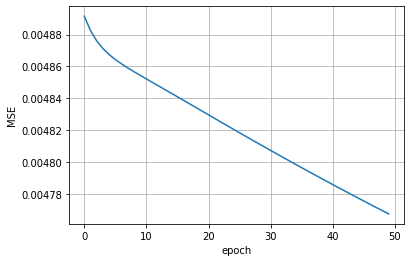

mean square error = 0.004767463640661244


In [0]:
users_bias,items_bias=Rcmdsys(adjacency_matrix,user_restuarant,50, 0.001, 0.01)

**CONCLUSION**

1) We can **user-user similarity** to find similar users and recommend most liked restaurant by majority of similar users

2) Problem with user-user similarity is users preferences change over time, we need to retrain the model over certain time period

3) Rating on a given restaurant do not change significially over time after the initial period we can find similar restaurants using **item-item similarity** and we can recommend

4) when a new user added to data matrix instead of re-training model on huge dataset we can use  **incrimental matrix** to get that new user vector

5) we can also post this problem as regression problem by using user and item vectors we can predict ratings , according to those ratings we can recommend the restaurants
